In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

### Data extracted
We consider weed data extracted from the field at 2021-05-31. Note that in early season MEXG index works well, however, this is not the case in mid or late season.

In [2]:
data=pd.read_csv('data.csv')
data.sample(10)

,area,perimeter,inertia11,inertia12,inertia21,inertia22,x,y,density_around,area_around,N,NW,img
15624,6.0,6.414214,0.916667,0.250000,0.250000,0.250000,427.500000,13.500000,14.0,0.0360,150.0,252.0,49.0
2396,5.0,5.207107,0.560000,0.120000,0.120000,0.240000,466.800000,35.400000,20.0,0.0616,150.0,63.0,8.0
15488,4.0,4.000000,0.250000,-0.000000,-0.000000,0.250000,106.500000,68.500000,23.0,0.0752,150.0,252.0,48.0
5437,14.0,12.035534,1.678571,-0.821429,-0.821429,1.352041,366.500000,22.928571,18.0,0.0752,150.0,79.0,17.0
6800,2.0,0.000000,0.000000,-0.000000,-0.000000,0.250000,149.000000,46.500000,15.0,0.0236,75.0,105.0,22.0
11672,6.0,6.242641,0.472222,0.138889,0.138889,0.472222,467.166667,31.833333,16.0,0.0372,150.0,154.0,37.0
4103,6.0,6.207107,0.666667,0.333333,0.333333,0.472222,377.000000,11.833333,19.0,0.0536,150.0,64.0,13.0
5544,3.0,3.414214,0.222222,0.111111,0.111111,0.222222,219.333333,44.333333,14.0,0.0452,150.0,79.0,17.0
18855,12.0,9.621320,1.743056,0.104167,0.104167,0.520833,348.916667,39.750000,17.0,0.0420,75.0,265.0,58.0
9145,4.0,4.000000,0.250000,-0.000000,-0.000000,0.250000,76.500000,84.500000,15.0,0.0516,150.0,134.0,29.0


In [3]:
data.shape

(20254, 13)

This means that we have 20254 weed regions on the field.

### Remove inconsistent data

In [4]:
indx=data['area'] >150
print(data.loc[indx]['img'])

6619    21.0
8766    28.0
Name: img, dtype: float64


In [5]:
data.loc[indx]

,area,perimeter,inertia11,inertia12,inertia21,inertia22,x,y,density_around,area_around,N,NW,img
6619,55688.0,1716.760497,35189.956716,25.490383,25.490383,612.381515,325.049131,42.597759,1.0,22.2752,150.0,105.0,21.0
8766,55844.0,1598.172619,35215.558365,4.160765,4.160765,615.560037,324.563570,42.513591,1.0,22.3376,150.0,134.0,28.0


In [6]:
indx_outl=(data['img']==21)|(data['img']==28)
data=data.loc[~indx_outl]

### Analysis

It there statistical difference in weed amount in N75 and N150 beds? Not really... 

In [7]:
sample75=np.array(data.loc[data['N']==75].groupby('img').count()['x']).flatten()
sample150=np.array(data.loc[data['N']==150].groupby('img').count()['x']).flatten()
scipy.stats.ttest_ind(sample75, sample150, equal_var=False)

Ttest_indResult(statistic=0.47598546733129354, pvalue=0.6358558090671917)

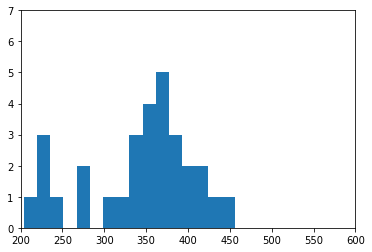

mean=330.78125


In [8]:
plt.hist(sample75,bins=20)
plt.xlim(200,600)
plt.ylim(0,7)
plt.show()
print(f'mean={sample75.mean()}')

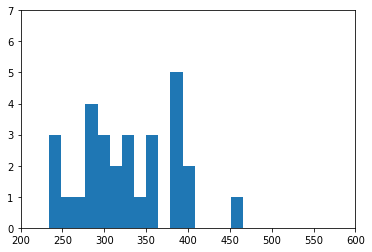

mean=322.23333333333335


In [9]:
plt.hist(sample150,bins=20)
plt.xlim(200,600)
plt.ylim(0,7)
plt.show()
print(f'mean={sample150.mean()}')

It there statistical difference in weed area in N75 and N150 beds?

In [10]:
area75=np.array(data.loc[data['N']==75].groupby('img').sum()['area']).flatten()
area150=np.array(data.loc[data['N']==150].groupby('img').sum()['area']).flatten()
scipy.stats.ttest_ind(area75, area150, equal_var=True)

Ttest_indResult(statistic=0.35188631551347155, pvalue=0.7261564136069957)

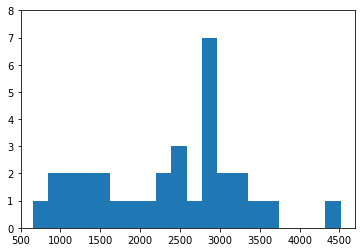

mean=2355.0


In [29]:
plt.hist(area75,bins=20)
plt.xlim(500,4700)
plt.ylim(0,8)
plt.show()
print(f'mean={area75.mean()}')

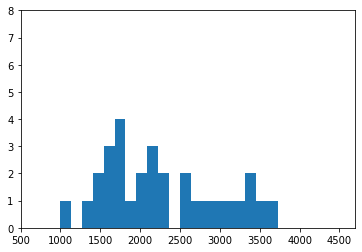

mean=2279.8


In [30]:
plt.hist(area150,bins=20)
plt.xlim(500,4700)
plt.ylim(0,8)
plt.show()
print(f'mean={area150.mean()}')

Data needs more processing.

### Some machine learning
Can we still predict Nitrogen rate (N) from weed features extracted?

First transform N=75;150 to categories 0;1

In [13]:
features=['area','perimeter','inertia11','inertia12','inertia21','inertia22','density_around','area_around','NW']

indx75=data['N']==75
data75=data.loc[indx75][features]
data75['category']=0

indx150=data['N']==150
data150=data.loc[indx150][features]
data150['category']=1

In [14]:
data=data75.append(data150)
data.sample(10)

,area,perimeter,inertia11,inertia12,inertia21,inertia22,density_around,area_around,NW,category
19257,2.0,0.000000,0.250000,0.250000,0.250000,0.250000,31.0,0.0532,274.0,1
6623,7.0,6.828427,0.571429,0.285714,0.285714,0.571429,20.0,0.0876,105.0,0
5027,16.0,12.000000,1.250000,-0.000000,-0.000000,1.250000,18.0,0.0608,79.0,1
7389,2.0,0.000000,0.250000,0.250000,0.250000,0.250000,25.0,0.1004,121.0,1
16023,2.0,0.000000,0.000000,-0.000000,-0.000000,0.250000,26.0,0.0576,252.0,0
12134,4.0,4.621320,0.187500,-0.000000,-0.000000,0.500000,19.0,0.0552,154.0,0
16741,14.0,11.656854,1.107143,0.464286,0.464286,1.311224,19.0,0.0680,252.0,0
16692,11.0,9.656854,0.545455,-0.000000,-0.000000,1.272727,15.0,0.0772,252.0,0
12242,5.0,5.207107,0.560000,0.120000,0.120000,0.240000,28.0,0.0612,154.0,0
19077,2.0,0.000000,0.250000,-0.000000,-0.000000,0.000000,22.0,0.0408,265.0,0


In [15]:
data['category']=data['category'].astype('category')

### Classifiers
Lets train some model to predict N rate

In [16]:
train, test = train_test_split(data, random_state = 111, test_size = 0.3) 
np.bincount(np.array(train['category']).flatten().astype('int32'))

array([7411, 6765], dtype=int32)

In [17]:
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3 = RandomForestClassifier()
model4 = LogisticRegression()
model5 = GradientBoostingClassifier(learning_rate=0.7)
model6 = MLPClassifier()

model1.fit(train[features],train[['category']])
model2.fit(train[features],train[['category']])
model3.fit(train[features],train[['category']])
model4.fit(train[features],train[['category']])
model5.fit(train[features],train[['category']])
model6.fit(train[features],train[['category']])

C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [18]:
print(f"Accuracy of DT is {model1.score(test[features],test[['category']])*100:.2f}%")
print(f"Accuracy of KNN is {model2.score(test[features],test[['category']])*100:.2f}%")
print(f"Accuracy of RF is {model3.score(test[features],test[['category']])*100:.2f}%")
print(f"Accuracy of Logit is {model4.score(test[features],test[['category']])*100:.2f}%")
print(f"Accuracy of GDM is {model5.score(test[features],test[['category']])*100:.2f}%")
print(f"Accuracy of MLP is {model6.score(test[features],test[['category']])*100:.2f}%")

Accuracy of DT is 58.87%
Accuracy of KNN is 58.62%
Accuracy of RF is 59.68%
Accuracy of Logit is 54.25%
Accuracy of GDM is 64.38%
Accuracy of MLP is 52.44%


### Meta-model
Lets create meta-model

In [19]:
train, remaining = train_test_split(data, random_state = 111, train_size = 0.5) 
val, test = train_test_split(remaining, random_state = 111, test_size = 0.4) 

C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
print(train.shape,val.shape,test.shape)

(10126, 10) (6075, 10) (4051, 10)


In [21]:
modela = KNeighborsClassifier()
modelb = RandomForestClassifier()
modelc = GradientBoostingClassifier(learning_rate=0.7)

modela.fit(train[features],train[['category']])
modelb.fit(train[features],train[['category']])
modelc.fit(train[features],train[['category']])

C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tr

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [22]:
proba=modela.predict_proba(val[features])
probb=modelb.predict_proba(val[features])
probc=modelc.predict_proba(val[features])
train_blending = np.concatenate([proba,probb,probc],axis = 1)

In [23]:
proba_test=modela.predict_proba(test[features]) 
probb_test=modelb.predict_proba(test[features])
probc_test=modelc.predict_proba(test[features])
test_blending = np.concatenate([proba_test,probb_test,probc_test],axis = 1)

In [24]:
blending_model = SVC()
blending_model.fit(train_blending, val['category'])

C:\Users\artjom\Miniconda3\envs\env36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [25]:
print(f"Accuracy of blending ensemble {blending_model.score(test_blending, test['category'])*100:.2f}%")

Accuracy of blending ensemble 63.76%


In [26]:
print(classification_report(test['category'], blending_model.predict(test_blending)))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      2123
           1       0.62      0.61      0.61      1928

   micro avg       0.64      0.64      0.64      4051
   macro avg       0.64      0.64      0.64      4051
weighted avg       0.64      0.64      0.64      4051

